In [ ]:
# default_exp custom_tf_training

# Custom Tensorflow Training

> Extending tf.keras for custom training functionality

In [ ]:
# export
import os
from nbdev.showdoc import *
from fastcore.test import *


import tensorflow as tf
import sklearn
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


test_eq(sklearn.__version__ > "0.20", True)
test_eq(tf.__version__ > "2.0.0", True)

In [ ]:
#hide
from nbdev.showdoc import *
TEMP_DIR = "tmp"
if not os.path.exists('tmp'):
    os.makedirs('tmp')

### Custom Loss Functions

In [ ]:
housing = sklearn.datasets.fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

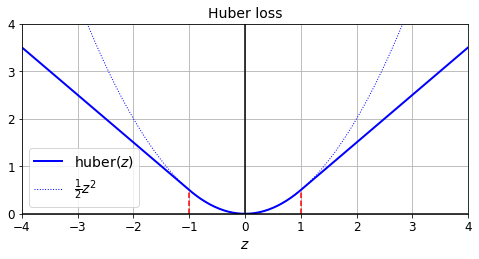

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [ ]:
input_shape = X_train.shape[1:]

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5551 - mae: 0.9130 - val_loss: 0.2643 - val_mae: 0.5597
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2140 - mae: 0.5107 - val_loss: 0.2213 - val_mae: 0.5097


In [ ]:
CUSTOM_MODEL = os.path.join(TEMP_DIR, "my_model_with_a_custom_loss.h5")
CUSTOM_MODEL_THRESHOLD = os.path.join(TEMP_DIR, "my_model_with_a_custom_loss_threshold.h5")
CUSTOM_MODEL_LOSS_CLASS = os.path.join(TEMP_DIR, "my_model_with_a_custom_loss_class.h5")
CUSTOM_MODEL_CUSTOM_PARTS = os.path.join(TEMP_DIR, "my_model_with_many_custom_parts.h5")
CUSTOM_MODEL_CUSTOM_PARTS_2 = os.path.join(TEMP_DIR, "my_model_with_many_custom_parts_2.h5")

In [ ]:
model.save(CUSTOM_MODEL)
del model

In [ ]:
model = tf.keras.models.load_model(CUSTOM_MODEL,
                    custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2060 - mean_absolute_error: 0.5003 - val_loss: 0.2042 - val_mean_absolute_error: 0.4890
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2012 - mean_absolute_error: 0.4935 - val_loss: 0.1877 - val_mean_absolute_error: 0.4741


In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2242 - mae: 0.4932 - val_loss: 0.2035 - val_mae: 0.4674
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2199 - mae: 0.4890 - val_loss: 0.1997 - val_mae: 0.4670


In [ ]:
model.save(CUSTOM_MODEL_THRESHOLD)
del model

In [ ]:
model = tf.keras.models.load_model(CUSTOM_MODEL_THRESHOLD, 
        custom_objects={"huber_fn": create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2168 - mean_absolute_error: 0.4848 - val_loss: 0.2171 - val_mean_absolute_error: 0.4631
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2144 - mean_absolute_error: 0.4819 - val_loss: 0.2168 - val_mean_absolute_error: 0.4673


In [ ]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7339 - mae: 0.9271 - val_loss: 0.5465 - val_mae: 0.6732
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2617 - mae: 0.5323 - val_loss: 0.3950 - val_mae: 0.5797


In [ ]:
model.save(CUSTOM_MODEL_LOSS_CLASS, save_format='h5')
# tf.saved_model.save(model, CUSTOM_MODEL_LOSS_CLASS)
# del model

In [ ]:
# open issue: https://github.com/tensorflow/tensorflow/issues/25938
# model = tf.keras.models.load_model(CUSTOM_MODEL_LOSS_CLASS, 
#                         {"HuberLoss": HuberLoss})

# model = tf.saved_model.load(CUSTOM_MODEL_LOSS_CLASS)                       

In [ ]:
# related to : https://github.com/tensorflow/tensorflow/issues/25938
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2432 - mae: 0.5113 - val_loss: 0.3272 - val_mae: 0.5405
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2323 - mae: 0.5007 - val_loss: 0.2340 - val_mae: 0.4888


Notes

Saving tensorflow models with custom components is still very clunky.
* Saving loss classes of `tf.keras.losses.Loss` throws errors (related to: [this PR](https://github.com/tensorflow/tensorflow/issues/25938)
* `h5py` works most cases except for saving `tf.keras.losses.Loss` classes.
* Ideally would like to save all of this as a `SavedModel`, due to integreation with tensroflow serving.

### Custom Activation Functions, Initializers, Regularizers and Constants

In [ ]:
def clear_keras_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
clear_keras_session()

In [ ]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)
clear_keras_session()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save(CUSTOM_MODEL_CUSTOM_PARTS)
del model

In [ ]:
model = tf.keras.models.load_model(
    CUSTOM_MODEL_CUSTOM_PARTS,
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}
clear_keras_session()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save(CUSTOM_MODEL_CUSTOM_PARTS_2)

In [ ]:
model = tf.keras.models.load_model(
    CUSTOM_MODEL_CUSTOM_PARTS_2,
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

### Custom Metrics

### Custom Layers

### Custom Models

### Losses and Metrics Based on Model Internals

### Computing Gradients Using Autodiff

### Custom Training Loops

## References
* [Ch 12: Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow](https://github.com/ageron/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb)